# MALA

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jn
from  matplotlib import pyplot as plt
import jax
from jax import random

from src.utils import l2sq
from src.algorithm import*

plt.rcParams["figure.figsize"]=8,8

[[2.1951485  1.2299898 ]
 [1.2299898  3.83718402]]


(-12.0, 12.0)

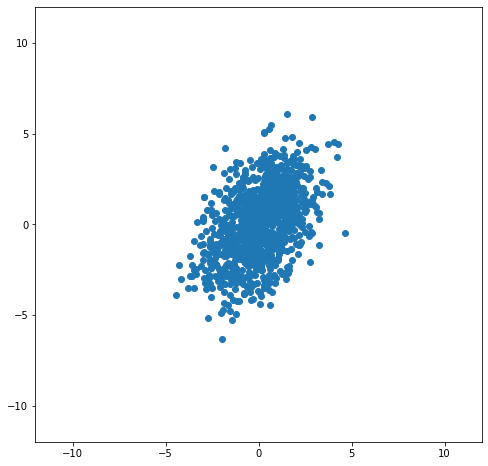

In [2]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

k = 2
M = jnp.zeros(k)
#c = jnp.array([[1,0],[0,10]])
#c_inv = jnp.array([[1, 0], [0,1/10]])

key, *sk = random.split(key, 4)
V = random.normal(sk[0], [k, k])
Q, _ = jnp.linalg.qr(V)
d = jnp.diag(random.uniform(sk[1], (k,))*10)
D= d.at[d < 0].set(0)
C = Q.transpose() @ D @ Q
C_inv = Q.transpose() @ jnp.diag(1/jnp.diag(D)) @ Q
print(C)

S = random.multivariate_normal(sk[2], M, C, (1000,))
plt.scatter(S[:,0], S[:,1])
plt.xlim(-12,12)
plt.ylim(-12,12)

In [36]:
logPi = lambda x : -1/2 * (x-M) @ C_inv @ (x-M) - jnp.log(jnp.sqrt((2*jnp.pi)**k * jnp.linalg.det(C)))
gradLogPi = jax.grad(logPi)

pi = lambda x : jnp.exp(logPi(x))
logPi = jax.jit(logPi)
gradLogPi = jax.jit(gradLogPi)

In [38]:
logPi(jnp.array([10,20]))
gradLogPi(jnp.array([0.,-5.]))

DeviceArray([-0.88996667,  1.58831317], dtype=float64)

In [ ]:
#x = jnp.arange(-20,20)
#y = [pi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y)
#plt.show
#y2 = [pi(jnp.array([xi,0])) for xi in x]
#plt.plot(x,y2)
#plt.show()
#y3 = [logPi(jnp.array([0,xi])) for xi in x]
#plt.plot(x,y3)

#gradLogPi(jnp.array([0.,-5.]))

In [7]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))
print(key)

[  0 176]


In [8]:
print(key)
key, sk1, sk2 = random.split(key,3)
print(key)
#print(random.normal(key))

print(sk1)
print(sk2)
#print(random.normal(subkey))


[  0 176]
[2827728980 1399233544]
[3030550828 2659192140]
[ 841176681 4150864534]


In [105]:
#x0 = jnp.zeros(k)
#x0 = jnp.array([20,0,-2])
x0 = jnp.array(np.random.randn(k))
tau = 1
N = 100

key, *keys = random.split(key, 2*N+1)

In [110]:
x1 = []
x1.append(x0)
rr = []
rr.append(1)
x1c = x0

t0 = time.time()
for i in jnp.arange(1, N):

    x1p = x1c
    x1c, r = mala_proposal(keys[2*i], logPi, gradLogPi, x1[i-1], tau)
    a = jnp.minimum(1, r)
    rr.append(a)
    
    x1c = jax.lax.cond(random.uniform(keys[2*i+1]) < a,
        true_fun = lambda _ : x1c,
        false_fun = lambda _ : x1p,
        operand = None)
    
    x1.append(x1c)
        
print("Time ", time.time()-t0)

x1 = jnp.array(x1)
rr = jnp.array(rr)

Time  0.6819913387298584


Mean error = 0.04893401508478727
Covariance error = 0.037753091112253494


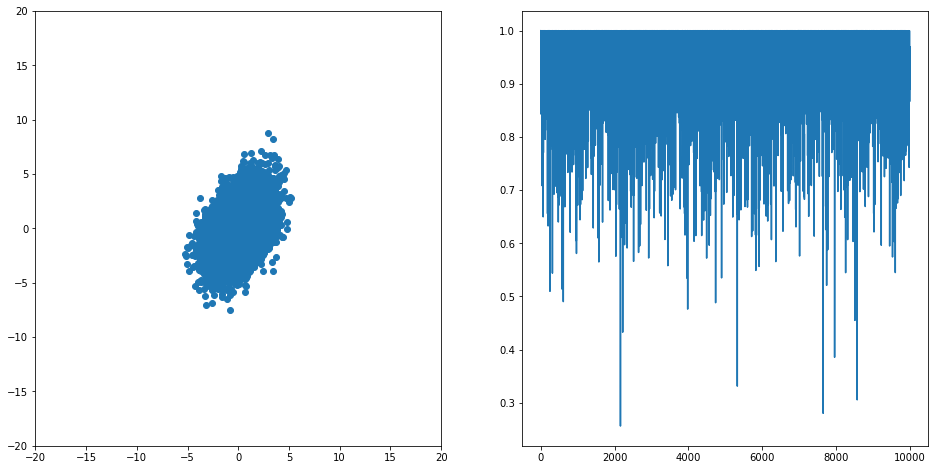

In [67]:
plt.rcParams["figure.figsize"]=16,8

plt.subplot(1,2,1)
plt.scatter(x1[:,0], x1[:,1])
plt.xlim(-20,20)
plt.ylim(-20,20)

plt.subplot(1,2,2)
plt.plot(rr)

plt.rcParams["figure.figsize"]=8,8

M_est = jnp.mean(x1, axis = 0)
print("Mean error =", jnp.linalg.norm(M - M_est))

C_est = jnp.cov(x1.transpose())
print("Covariance error =", jnp.linalg.norm(C - C_est)/jnp.linalg.norm(C))

In [102]:
t0 = time.time()
mala_proposal(key, logPi, gradLogPi, x1[0], tau)
print(time.time() - t0)

0.002933979034423828
